In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import captum
from PIL import Image

ModuleNotFoundError: No module named 'torch'

In [2]:
CELLTYPES = {
    "basophil" : 0,
    "eosinophil" : 1,
    "erythroblast" : 2,
    "ig" : 3,
    "lymphocyte" : 4,
    "monocyte" : 5,
    "neutrophil" : 6,
    "platelet" : 7,
}

Converts images into tensors -> compresses them in 32x32 pixel images -> include 4 rotations of each images.

In [4]:
image_tensors = []
target_tensors = []

for key, value in CELLTYPES.items():
    folder_path = os.path.join(os.getcwd() + "/data/images", key)

    # go thorugh jpg images in the folder
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        image = Image.open(image_path)
        image = image.resize((32, 32))
        image_tensor = torch.tensor(np.array(image))
        for angle in range(0, 360, 90):
            rotated_image = torch.rot90(image_tensor, 1, [0, 1])
            # append the image as channel, 32, 32
            image_tensors.append(rotated_image.permute(2, 0, 1))
            target_tensors.append(value)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/simonboudara/Cours_info/UE22/data/images/basophil'

Separate data into training, testing and validation sets.

In [84]:
data = list(zip(image_tensors, target_tensors))
random.shuffle(data)
image_tensors, target_tensors = zip(*data)

train_data = image_tensors[:int(len(image_tensors) * 0.8)]
train_targets = target_tensors[:int(len(target_tensors) * 0.8)]

test_data = image_tensors[int(len(image_tensors) * 0.8):int(len(image_tensors) * 0.9)]
test_targets = target_tensors[int(len(target_tensors) * 0.8):int(len(target_tensors) * 0.9)]

val_data = image_tensors[int(len(image_tensors) * 0.9):]
val_targets = target_tensors[int(len(target_tensors) * 0.9):]

train_data = torch.stack(train_data).float()
train_targets = torch.tensor(train_targets).long()

test_data = torch.stack(test_data).float()
test_targets = torch.tensor(test_targets).long()

val_data = torch.stack(val_data).float()
val_targets = torch.tensor(val_targets).long()


In [85]:
class CNN(nn.Module):

    def __init__(self, output_size):

        super(CNN, self).__init__()

        self.conv = nn.Sequential(
            # block 1:         3 x 32 x 32 --> 64 x 16 x 16        
            nn.Conv2d(3,   64,  kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.Conv2d(64,  64,  kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # block 2:         64 x 16 x 16 --> 128 x 8 x 8
            nn.Conv2d(64,  128, kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
            nn.Conv2d(128, 256, kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            #block 4:          256 x 4 x 4 --> 512 x 2 x 2
            nn.Conv2d(256, 512, kernel_size=3, padding=1 ),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.linear = nn.Sequential(
            # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
            nn.Linear(2048, 4096),
            nn.Linear(4096, 4096),
            nn.Linear(4096, output_size)
        )


    def forward(self, x):

        x = self.conv(x)
        x = x.view(-1, 2048)
        x = self.linear(x) 
        
        return x

In [86]:
CNN_model = CNN(CELLTYPES.__len__())

In [87]:
CNN_criterion = nn.CrossEntropyLoss()
CNN_lr = 0.001 
batch_size = 50

In [88]:
def get_error(scores, target):
    batch_size = scores.size(0)
    predicted_targets = scores.argmax(dim=1)
    indicator = (predicted_targets == target)
    num_matches = indicator.sum()
    
    return 1-num_matches.float() / batch_size

Evaluation function to test model on the fly so that we can know if we are underfitting/overfitting to minimise time wastage.

In [95]:
num_test_data = len(test_data)
mean = test_data.mean()
std = test_data.std()

def eval_on_test_set(net, labels):

    running_error = 0
    num_batches = 0

    for i in range(0, num_test_data, batch_size):

        minibatch_data =  test_data[i:i+batch_size]
        minibatch_label = labels[i:i+batch_size]

        inputs = (minibatch_data - mean)/std

        scores = net(inputs) 

        error = get_error(scores , minibatch_label)

        running_error += error.item()

        num_batches += 1

    total_error = running_error/num_batches

    print('test error=', total_error*100, 'percent')

In [96]:
num_val_data = len(val_data)
mean = val_data.mean()
std = val_data.std()

def eval_on_val_set(net, labels):
    running_error = 0
    num_batches = 0

    for i in range(0, num_val_data, batch_size):

        minibatch_data =  val_data[i:i+batch_size]
        minibatch_label = labels[i:i+batch_size]

        inputs = (minibatch_data - mean)/std

        scores = net(inputs) 

        error = get_error(scores , minibatch_label)

        running_error += error.item()

        num_batches += 1

    total_error = running_error/num_batches

    print('validation error=', total_error*100, 'percent')

In [93]:
# Modify training data size and epoch count on need, minimised to speed up training

num_train_data = len(train_data)//5
start = time.time()
mean = train_data.mean()
std = train_data.std()

for epoch in range(5):
    
    # create a new optimizer at the beginning of each epoch; give the current learning rate.   
    brand_Adam_CNN_optimizer = torch.optim.Adam(CNN_model.parameters(), lr=CNN_lr)
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss = 0
    running_error = 0
    num_batches = 0
    
    # set the order in which to visit the image from the training set
    shuffled_indices = torch.randperm(num_train_data)
 
    for count in range(0, num_train_data, batch_size):
    
        # Set the gradients to zeros
        brand_Adam_CNN_optimizer.zero_grad()
        
        # Create a minibatch       
        indices = shuffled_indices[count:count+batch_size]
        minibatch_data = train_data[indices]
        minibatch_target = train_targets[indices] # difference between brand & type training
        
        # Normalize the minibatch
        inputs = (minibatch_data - mean)/std
        
        # Tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # Forward the minibatch through the net 
        scores = CNN_model(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        brand_loss = CNN_criterion(scores, minibatch_target) 
        
        # Backward pass to compute dL/dU, dL/dV and dL/dW
        brand_loss.backward()

        # Do one step of the optimizer
        brand_Adam_CNN_optimizer.step()
        
        # START COMPUTING STATS
        
        # Add the loss of this batch to the running loss
        running_loss += brand_loss.detach().item()
        
        # Compute the error made on this batch and add it to the running error       
        brand_error = get_error(scores.detach(), minibatch_target)
        running_error += brand_error.item()

        num_batches += 1        
    
    
    # compute stats for the full training set
    total_brand_loss = running_loss/num_batches
    total_brand_error = running_error/num_batches
    elapsed = (time.time()-start)/60

    print('epoch=', epoch + 1, '\t total time=', elapsed, 'min', '\t lr=', CNN_lr, '\t loss=', total_brand_loss, '\t error=', total_brand_error*100, 'percent')

    eval_on_test_set(CNN_model, test_targets) 
    print(' ')
    
# Save the model
torch.save(CNN_model.state_dict(), 'CNN_model.pth')

epoch= 0 	 total time= 3.2178667187690735 min 	 lr= 0.001 	 loss= 0.48680905637131433 	 error= 18.806056698707685 percent
test error= 17.073190734334233 percent
 
epoch= 1 	 total time= 7.194562796751658 min 	 lr= 0.001 	 loss= 0.4317232664317301 	 error= 15.880798286498955 percent
test error= 12.366542154855102 percent
 
epoch= 2 	 total time= 10.876904300848643 min 	 lr= 0.001 	 loss= 0.33541037315783434 	 error= 12.200433151907028 percent
test error= 9.49575883628678 percent
 
epoch= 3 	 total time= 14.329451882839203 min 	 lr= 0.001 	 loss= 0.3096294865250315 	 error= 10.355684120361119 percent
test error= 11.286250344158088 percent
 
epoch= 4 	 total time= 18.12865208387375 min 	 lr= 0.001 	 loss= 0.2754889887217517 	 error= 9.23816428336923 percent
test error= 8.27816159185702 percent
 


In [ ]:
# Load the model
CNN_model = CNN("CNN_model.pth")

In [97]:
# Evaluate the model on the test set
eval_on_test_set(CNN_model, test_targets)

# Evaluate the model on the validation set
eval_on_val_set(CNN_model, val_targets)

test error= 8.27816159185702 percent
validation error= 8.848294071907544 percent


In [109]:
def show_probability(probabilities):
    fig, ax = plt.subplots()
    ax.bar(CELLTYPES.keys(), probabilities)
    ax.set_ylabel('Probability')
    ax.set_xlabel('Cell Type')
    plt.xticks(rotation=45)
    plt.show()

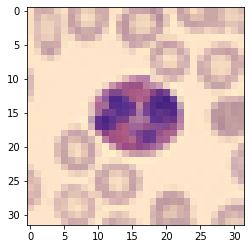

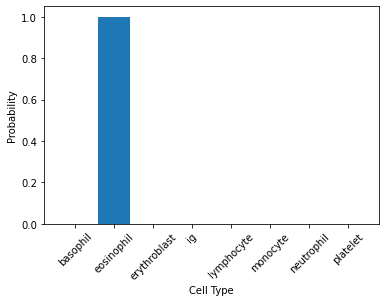

Predicted:  eosinophil
Actual:  eosinophil


In [110]:
image_index = random.randint(0, len(test_data))
image = test_data[image_index]

# convert image to displayable format
display_image = image.permute(1, 2, 0).numpy().astype(np.uint8)
plt.imshow(display_image)

image = (image - mean) / std
image = image.view(1, 3, 32, 32)

scores = CNN_model(image)
probabilities = nn.functional.softmax(scores, dim=1).detach().numpy()[0]
show_probability(probabilities)

print("Predicted: ", list(CELLTYPES.keys())[probabilities.argmax()])
print("Actual: ", list(CELLTYPES.keys())[test_targets[image_index]])

True target:  neutrophil


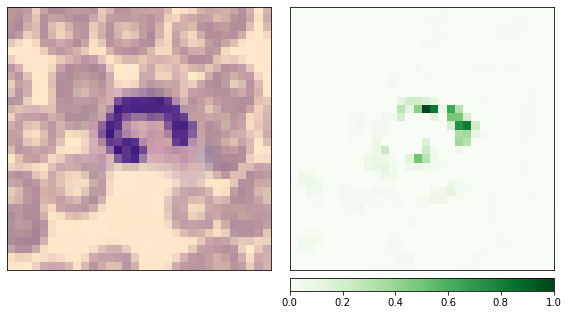

In [125]:
image_index = random.randint(0, len(test_data))
image = test_data[image_index]

original_image = image
image = (image - mean) / std
image = image.view(1, 3, 32, 32)
scores = CNN_model(image)

assert torch.argmax(scores) == test_targets[image_index]

print("True target: ", list(CELLTYPES.keys())[test_targets[image_index]])

ig = captum.attr.IntegratedGradients(CNN_model)
attribution = (ig.attribute(image, target=test_targets[image_index]))


_ = captum.attr.visualization.visualize_image_attr_multiple(np.transpose(attribution.squeeze().numpy(), (1,2,0)), 
                                                   np.transpose(original_image.squeeze().numpy(), (1,2,0)).astype(np.uint8), 
                                                   methods=["original_image", "heat_map"],
                                                   signs=['all', 'positive'],
                                                   show_colorbar =True)